<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#The-Euro-Problem" data-toc-modified-id="The-Euro-Problem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Euro Problem</a></span><ul class="toc-item"><li><span><a href="#Exercise-1" data-toc-modified-id="Exercise-1-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Exercise 1</a></span><ul class="toc-item"><li><span><a href="#Swamping-the-prior" data-toc-modified-id="Swamping-the-prior-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Swamping the prior</a></span></li></ul></li></ul></li></ul></div>

# Introduction

This notebook contains solutions to the [euro notebook](https://github.com/AllenDowney/BayesMadeSimple/blob/master/03_euro_soln.ipynb).

# Libraries

In [1]:
using Gen
using Statistics
using Plots
using DataStructures
using Printf
using StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1242
┌ Warning: Module Distances with build ID 5030259769548 is missing from the cache.
│ This may mean Distances [b4f34e82-e78d-54a5-968a-f98e89d6e8f7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1000
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
│   exception = Required dependency Distances [b4f34e82-e78d-54a5-968a-f98e89d6e8f7] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
│   exception = Required dependency AxisAlgorithms [13072b0f-2c55-5437-9ae7-d433b7a33950] failed to load from a cache file.
└ @ Base loading.jl:1025
┌ Warning: The call to compilecache failed to create a usable precompiled cache file 

# The Euro Problem

**Question**

From “The Guardian” quoted by MacKay, Information Theory, Inference, and Learning Algorithms:

>"When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. 'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics. 'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.' "

## Exercise 1

Solve the Euro Problem.

Let's assume a uniform prior.

Build the model:

In [2]:
@gen function spin_coin(spins::Int)
    prob_heads = @trace(uniform_discrete(0, 100), :prob_heads)
    
    for i in 1:spins
        @trace(bernoulli(prob_heads/100), (:spin, i))
    end
end;

Plot the prior distribution:

In [3]:
outcomes = Array{Int, 1}()

for _ in 1:100000
    trace, _ = Gen.generate(spin_coin, (1,))
    push!(outcomes, trace[:prob_heads])
end

In [4]:
function plot_distribution(outcomes::Array{Int, 1}, title::String)
    bins = length(unique(outcomes))
    histogram(outcomes, 
              legend=false, 
              xlabel="Probability of heads", 
              ylabel="PMF", 
              title=title, 
              normalize=:probability, 
              bins=bins)
end;

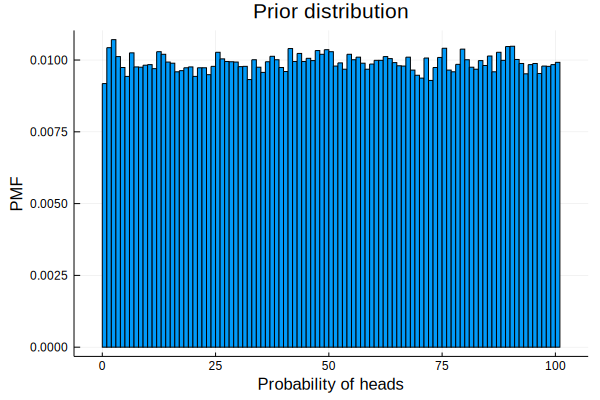

In [5]:
plot_distribution(outcomes, "Prior distribution")

If we update the posterior after observing one heads:

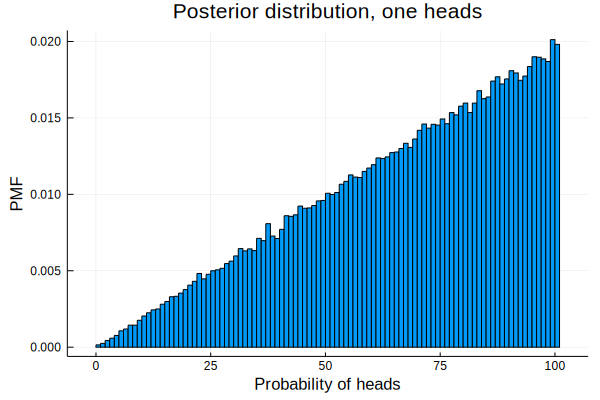

In [6]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap((:spin, 1) => 1)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (1,), observations, 100)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution, one heads")

If we observed two heads:

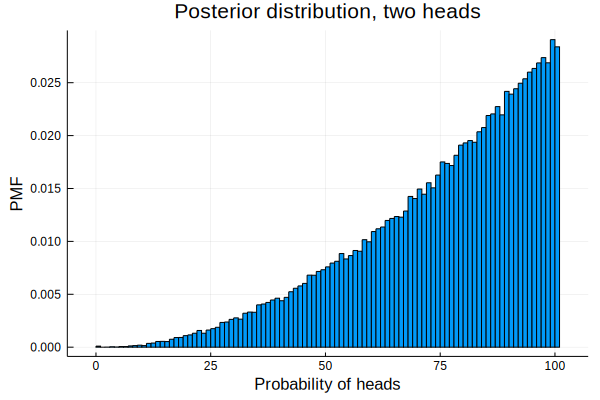

In [7]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap((:spin, 1) => 1, (:spin, 2) => 1)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (2,), observations, 100)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution, two heads")

If we observed two heads and a tail:

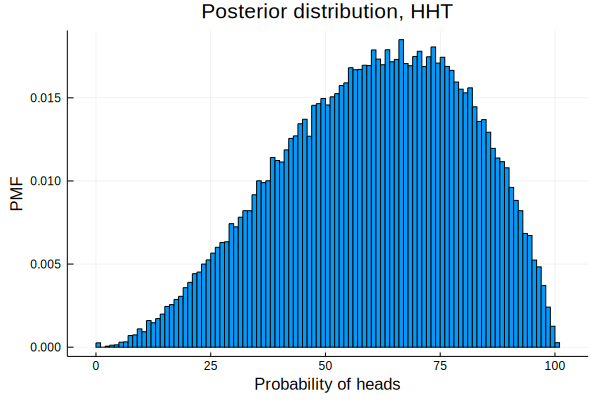

In [8]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap((:spin, 1) => 1, (:spin, 2) => 1, (:spin, 3) => 0)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (3,), observations, 100)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution, HHT")

If we observed 7 heads and 3 tails:

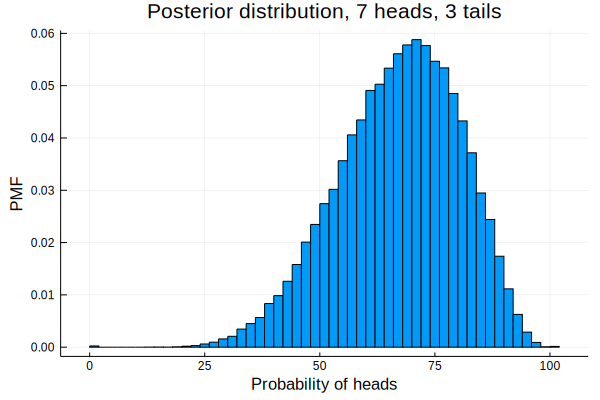

In [9]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap()

for i in 1:7
    observations[(:spin, i)] = 1
end

for i in 8:10
    observations[(:spin, i)] = 0
end

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (10,), observations, 100)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution, 7 heads, 3 tails")

Compute the maximum aposterior probability (MAP):

In [10]:
function compute_map(outcomes::Array{Int, 1})

    c = counter(outcomes)

    v = collect(values(c))
    k = collect(keys(c))

    max_prob = k[argmax(v)]
    
    return max_prob
end;

In [11]:
@sprintf "The MAP is %d" compute_map(outcomes)

"The MAP is 70"

If we observed 140 heads and 110 tails:

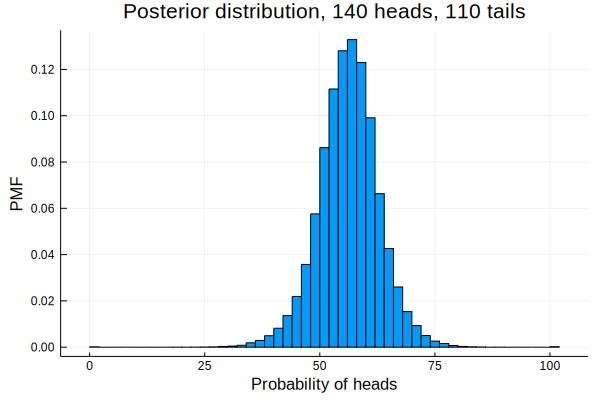

In [12]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap()

for i in 1:140
    observations[(:spin, i)] = 1
end

for i in 141:250
    observations[(:spin, i)] = 0
end

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (250,), observations, 10)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution, 140 heads, 110 tails")

In [13]:
@sprintf "The posterior mean is %.2f" mean(outcomes)

"The posterior mean is 55.79"

In [14]:
@sprintf "The MAP is %d" compute_map(outcomes)

"The MAP is 55"

### Swamping the prior

We will build a triangle distibution from a Categorical distribution:

In [15]:
function build_triangular_probs()
    max_outcome = 100
    min_outcome = 0
    middle_outcome = 50

    # formula from https://en.wikipedia.org/wiki/Triangular_distribution
    # need to add 1 because arrays are 1-indexed in Julia
    a = min_outcome + 1
    b = max_outcome + 1
    c = middle_outcome + 1

    probs = zeros(b)
    for x in 1:length(probs)
        probs[x] = ((b - c) - abs(c - x))/(b - c)^2
    end
    
    return probs
end;

Build the model:

In [16]:
@gen function spin_coin(spins::Int)
    triangular_probs = build_triangular_probs()
    
    prob_heads = categorical(triangular_probs)
    prob_heads = @trace(normal(prob_heads - 1, 0), :prob_heads)
    
    for i in 1:spins
        @trace(bernoulli(prob_heads/100), (:spin, i))
    end
end;

Sample from the prior:

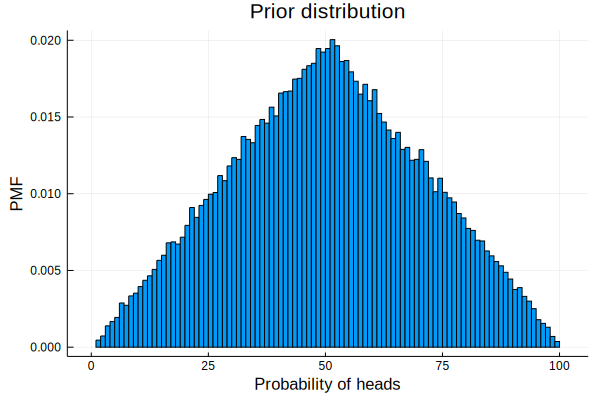

In [17]:
outcomes = Array{Int, 1}()

for _ in 1:100000
    trace, _ = Gen.generate(spin_coin, (1,))
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Prior distribution")

In [18]:
out1 = @sprintf "The expected outcome is %.2f" mean(outcomes)
out2 = @sprintf "The minimum outcome is %.2f" min(outcomes...)/100
out3 = @sprintf "The maximum outcome is %.2f" max(outcomes...)/100

println(out1)
println(out2)
println(out3)

The expected outcome is 49.92
The minimum outcome is 0.01
The maximum outcome is 0.99


Now, if we had observed 140 heads and 110 tails with a triangular prior:

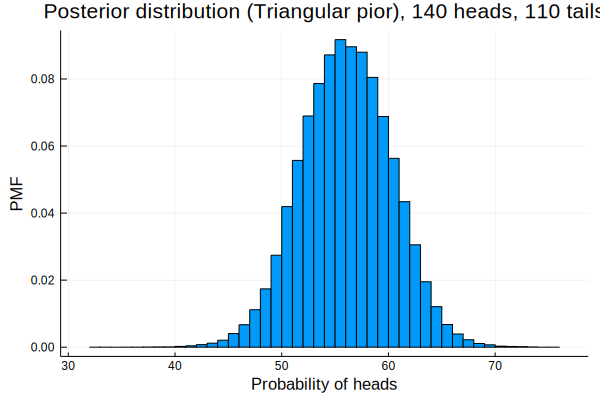

In [19]:
outcomes = Array{Int, 1}()
observations = Gen.choicemap()

for i in 1:140
    observations[(:spin, i)] = 1
end

for i in 141:250
    observations[(:spin, i)] = 0
end

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(spin_coin, (250,), observations, 10)
    push!(outcomes, trace[:prob_heads])
end

plot_distribution(outcomes, "Posterior distribution (Triangular pior), 140 heads, 110 tails")

In [20]:
@sprintf "The posterior mean is %.2f" mean(outcomes)

"The posterior mean is 55.55"

In [21]:
@sprintf "The MAP is %d" compute_map(outcomes)

"The MAP is 55"

Notice that results are nearly identical with the case where the assumption for the prior was a uniform distribution.